In [1]:
import pandas as pd
from openpyxl import load_workbook
import lagrangian_case as lc
import numpy as np
import matplotlib.pyplot as plt
import os
import utils
import random
import met_utils as mu
import xarray as xr
from scipy import stats
old_settings = np.seterr(invalid='ignore')  #seterr to known value
import warnings
warnings.simplefilter("ignore")
%load_ext autoreload
%autoreload 2

In [ ]:
print(combined_cases[6].ALC)
flight_data = combined_cases[6].ALC.outbound_flight_data
leg = 'b'
seq = 'C'
print(f'{str(min(flight_data.time[good_index].values))[:-10]} to {str(max(flight_data.time[good_index].values))[:-10]}')

In [9]:
combined_cases = {}
for key, case in lc.all_cases.items():
    if key not in [6, 10]:
        continue
    print(key)
    TLC = lc.TrajectoryCase(case['TLC_name'])
    TLC.add_traj_data()
    ALC = lc.AircraftCase(case['ALC_name'])
    ALC.add_ERA_data()
#     ALC.add_precip_data()
    CLC = lc.CombinedCase(ALC, TLC, number=key)
    combined_cases[key] = CLC
#     CLC.plot(save=True)
    

6
in insitu
<xarray.Dataset>
Dimensions:                 (Time: 24901, Vector100: 100, Vector129: 129, Vector257: 257, Vector31: 31, Vector64: 64, interarrival_endpoints: 41, sps1: 1)
Coordinates:
  * Time                    (Time) datetime64[ns] 2015-07-17T14:55:00 ... 2015-07-17T21:50:00
  * interarrival_endpoints  (interarrival_endpoints) float32 1e-07 ... 10.0
Dimensions without coordinates: Vector100, Vector129, Vector257, Vector31, Vector64, sps1
Data variables:
    ACINS                   (Time) float32 ...
    ADIFR                   (Time) float32 ...
    ALT                     (Time) float32 ...
    BDIFR                   (Time) float32 ...
    BLATA                   (Time) float32 ...
    BLONGA                  (Time) float32 ...
    BNORMA                  (Time) float32 ...
    CNTS                    (Time) float32 ...
    GGALT                   (Time) float32 ...
    GGALTSD                 (Time) float32 ...
    GGDAGE                  (Time) float32 ...
    GGLAT 

In [438]:
out_ret_vars = ['GOES_CF', 'EIS', 'LTS', 'delta_q', 'delta_T', 'CDP_Nd', 'CDP_Nd_p', 'zi', 'alpha_dec', 'UHSAS_Na',
                'UHSAS_Na_cld', 'median_prec', 'prec_freq', 'cond_prec',# 'prec_freq_PZ',
                'mean_prec', 'cond_prec_PZ', 'O3', 'CO', 'SST', 'FT_RH', 'FT_q', 'FT_theta', 'zi_traj', 'lon_p']
fixed_vars = ['out_flight', 'out_seqs', 'ret_flight', 'ret_seqs', 'trajs', 'out_time', 'ret_time']
cols = fixed_vars[:]
[[cols.append('out_'+i), cols.append('ret_'+i), cols.append('diff_'+i)] for i in out_ret_vars]
laone_vars = ['subs', 'subs_err', 'entr', 'entr_TLC', 'dzidt_ALC', 'subs_700', 'shf', 'lhf']
cols = cols + lone_vars


#to add: plane_CF, sfc_fluxes

df = pd.DataFrame(index=list(lc.all_cases.keys()) + ['lower_quartile', 'upper_quartile', 'mean'], columns=cols)

science rows:

casenum | CF (out,ret) | EIS (out,ret) | decoupling (out,ret) | zi (out,ret) | rain_rate (out,ret) | plane_Nd (out,ret) | Na (out,ret) | 




housekeeping rows:

out_seqs | ret_seqs| trajs | out_starttime | out_endtime | ret_starttime | ret_endtime | out_length | ret_length

In [439]:
for num, case in combined_cases.items():
    print(num)
    df['out_flight'][num] = case.ALC.outbound_flight
    df['out_seqs'][num] = case.ALC.outbound_sequences
    df['ret_flight'][num] = case.ALC.return_flight
    df['ret_seqs'][num] = case.ALC.return_sequences
    df['trajs'][num] = case.TLC.trajectories
    df['out_time'][num] = case.ALC.outbound_flight_data.time.values[int(len(case.ALC.outbound_flight_data.time.values)/2)]
    df['ret_time'][num] = case.ALC.return_flight_data.time.values[int(len(case.ALC.return_flight_data.time.values)/2)]
    
    out_lat = case.ALC.outbound_flight_data.GGLAT.values[int(len(case.ALC.outbound_flight_data.GGLAT.values)/2)]
    out_lon = case.ALC.outbound_flight_data.GGLON.values[int(len(case.ALC.outbound_flight_data.GGLON.values)/2)]
    ret_lat = case.ALC.return_flight_data.GGLAT.values[int(len(case.ALC.return_flight_data.GGLAT.values)/2)]
    ret_lon = case.ALC.return_flight_data.GGLON.values[int(len(case.ALC.return_flight_data.GGLON.values)/2)]
    
    df['out_lon_p'][num] = utils.get_lon_prime(out_lat, out_lon)
    df['ret_lon_p'][num] = utils.get_lon_prime(ret_lat, ret_lon)
    
    
    df['out_GOES_CF'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.GOES_data['2deg'].warm_low_cloud_fraction)
    df['ret_GOES_CF'][num] = np.nanmean(case.ALC.return_Flight_Piece.GOES_data['2deg'].warm_low_cloud_fraction)
    df['out_CDP_Nd'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CONCD_LWOI', legname='c', cloud_only=True).values)
    df['out_EIS'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_EIS.values)
    df['ret_EIS'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_EIS.values)
    df['out_SST'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_sst.values)
    df['ret_SST'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_sst.values)
    df['out_LTS'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_LTS.values)
    df['ret_LTS'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_LTS.values)
    df['ret_CDP_Nd'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CONCD_LWOI', legname='c', cloud_only=True).values)
    df['out_CDP_Nd_p'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CONCD_LWOI', legname='p', cloud_only=True).values)
    df['ret_CDP_Nd_p'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CONCD_LWOI', legname='p', cloud_only=True).values)

    out_profs = case.ALC.outbound_Flight_Piece.get_profiles()
    ret_profs = case.ALC.return_Flight_Piece.get_profiles()

    df['out_zi'][num] = np.nanmean([i['dec']['z_bot'] for i in out_profs.values()])
    df['ret_zi'][num] = np.nanmean([i['dec']['z_bot'] for i in ret_profs.values()])
    df['out_alpha_dec'][num] = np.nanmean([i['dec']['alpha_qt'] for i in out_profs.values()])
    df['ret_alpha_dec'][num] = np.nanmean([i['dec']['alpha_qt'] for i in ret_profs.values()])
    
    df['out_delta_T'][num] = np.nanmean([i['dec']['d_t_inv'] for i in out_profs.values()])
    df['ret_delta_T'][num] = np.nanmean([i['dec']['d_t_inv'] for i in ret_profs.values()])

    df['out_delta_q'][num] = np.nanmean([i['dec']['d_q_inv'] for i in out_profs.values()])
    df['ret_delta_q'][num] = np.nanmean([i['dec']['d_q_inv'] for i in ret_profs.values()])
    
    
    
    
    df['out_UHSAS_Na'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CONCU100_RWOOU', legname='b', cloud_only=True, flip_cloud_mask=True).values)
    df['ret_UHSAS_Na'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CONCU100_RWOOU', legname='b', cloud_only=True, flip_cloud_mask=True).values)
    
    df['out_UHSAS_Na_cld'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CONCU100_RWOOU', legname='c', cloud_only=True, flip_cloud_mask=True).values)
    df['ret_UHSAS_Na_cld'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CONCU100_RWOOU', legname='c', cloud_only=True, flip_cloud_mask=True).values)
    
    
    out_prcp = case.ALC.outbound_Flight_Piece.get_max_precip_by_leg(legname='b').values*3.6*24
    ret_prcp = case.ALC.return_Flight_Piece.get_max_precip_by_leg(legname='b').values*3.6*24
    df['out_cond_prec'][num] = np.nanmean(out_prcp)
    df['ret_cond_prec'][num] = np.nanmean(ret_prcp)
    df['out_prec_freq'][num] = sum(~np.isnan(out_prcp))/len(out_prcp)
    df['ret_prec_freq'][num] = sum(~np.isnan(ret_prcp))/len(ret_prcp)
    df['out_mean_prec'][num] = np.nansum(out_prcp)/len(out_prcp)
    df['ret_mean_prec'][num] = np.nansum(ret_prcp)/len(ret_prcp)
    df['out_cond_prec_PZ'][num] = np.nanmean(out_prcp[out_prcp>0.24]) # >0.01 mm/hr, or 0.24 mm/day
    df['ret_cond_prec_PZ'][num] = np.nanmean(ret_prcp[ret_prcp>0.24])
#     df['out_prec_freq_PZ'][num] = sum(out_prcp>0.24)/len(out_prcp)
#     df['ret_prec_freq_PZ'][num] = sum(ret_prcp>0.24)/len(ret_prcp)
    df['out_median_prec'][num] = np.nanmedian(out_prcp)
    df['ret_median_prec'][num] = np.nanmedian(ret_prcp)
        
    
    df['out_CO'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CO', legname='b', cloud_only=False).values)
    df['ret_CO'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CO', legname='b', cloud_only=False).values)
    
    df['out_O3'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='O3', legname='b', cloud_only=False).values)
    df['ret_O3'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='O3', legname='b', cloud_only=False).values)
    df['out_FT_RH'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_r.sel(level=700).values)
    df['ret_FT_RH'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_r.sel(level=700).values)
    
    df['out_FT_q'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_q.sel(level=700).values)*1000
    df['ret_FT_q'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_q.sel(level=700).values)*1000
    
    
    df['out_FT_theta'][num] = np.nanmean(mu.theta_from_p_T(700, case.ALC.outbound_Flight_Piece.ERA_data.ERA_t.sel(level=700).values))
    df['ret_FT_theta'][num] = np.nanmean(mu.theta_from_p_T(700, case.ALC.return_Flight_Piece.ERA_data.ERA_t.sel(level=700).values))
    

    #doing subsidence and entrainment
# OLD WAY
#     subs_vals = []
#     for k,v in case.TLC.get_from_inv('ERA_w_vert').items():
#         index = np.logical_and(case.TLC.traj_data[k].time > df['out_time'][num], case.TLC.traj_data[k].time < df['ret_time'][num])
#         subs_vals.append(np.nanmean(v[index]))
#     df['subs'][num] = np.nanmean(subs_vals)*1000
    
    subs_vals = []
    for k,v in case.TLC.get_from_inv('ERA_ens_w_vert', ens=True).items():
        assert(v.shape[1] == 10)
        for i, mem in enumerate(v.T):
            index = np.logical_and(case.TLC.traj_data[k].time > df['out_time'][num], case.TLC.traj_data[k].time < df['ret_time'][num])
            subs_vals.append(np.nanmean(mem[index]))
    df['subs'][num] = np.nanmean(subs_vals)*1000
    df['subs_err'][num] = np.nanstd(subs_vals)*1000

    
    subs_700_vals = []
    shf_vals = []
    lhf_vals = []

    for k,v in case.TLC.traj_data.items():
        subs_700_vals.append(np.nanmean(v['ERA_w_vert'].sel(level=700, time=slice(df['out_time'][num], df['ret_time'][num]))))
        shf_vals.append(-np.nanmean(v['ERA_ishf'].sel(time=slice(df['out_time'][num], df['ret_time'][num]))))
        lhf_vals.append(-np.nanmean(v['ERA_ie'].sel(time=slice(df['out_time'][num], df['ret_time'][num])))*2.4625*1e6)
    
    df['subs_700'][num] = np.nanmean(subs_700_vals)*1000
    df['shf'][num] = np.nanmean(shf_vals)
    df['lhf'][num] = np.nanmean(lhf_vals)

    
    
    dzdt_ALC = (df['ret_zi'][num] - df['out_zi'][num])/(utils.as_datetime(df['ret_time'][num]) - utils.as_datetime(df['out_time'][num])).total_seconds()*1000
    df['dzidt_ALC'][num] = dzdt_ALC
    df['entr'][num] = dzdt_ALC - df['subs'][num]
    

    zi_init_vals = []
    zi_final_vals = []
    for k,v in case.TLC.get_from_inv('z_i').items():
            zi_init_vals.append(v[np.argmin(np.abs(case.TLC.traj_data[k].time.values - df['out_time'][num]))])
            zi_final_vals.append(v[np.argmin(np.abs(case.TLC.traj_data[k].time.values - df['ret_time'][num]))])

    df['out_zi_traj'][num] = np.nanmean(zi_init_vals)
    df['ret_zi_traj'][num] = np.nanmean(zi_final_vals)
            
            
    dzdt_TLC = (df['ret_zi_traj'][num] - df['out_zi_traj'][num])/(utils.as_datetime(df['ret_time'][num]) - utils.as_datetime(df['out_time'][num])).total_seconds()*1000
    df['entr_TLC'][num] = dzdt_TLC - df['subs'][num]
    


    ['plane_CF']
    
    
    for v in out_ret_vars:
        df['diff_'+v][num] = df['ret_'+v][num] - df['out_'+v][num]

for v in [i for i in df.keys() if i not in fixed_vars]:
    vals = df[v][0:18].astype('float')
    df[v]['mean'] = np.nanmean(vals)
    df[v]['lower_quartile'] = np.nanpercentile(vals, 10)
    df[v]['upper_quartile'] = np.nanpercentile(vals, 90)
        
print("done")

1
2
3
4
5
6
7
8
9
10
11
12
muck up on case Type: Trajectory Lagrangian
Name: TLC_RF10-RF11_1.0-1.5
Flights: RF10, RF11, traj 1.0, i=70
muck up on case Type: Trajectory Lagrangian
Name: TLC_RF10-RF11_1.0-1.5
Flights: RF10, RF11, traj 1.0, i=71
muck up on case Type: Trajectory Lagrangian
Name: TLC_RF10-RF11_1.0-1.5
Flights: RF10, RF11, traj 1.0, i=72
13
14
15
16
17
18
done


In [420]:
for n in [6, 10]:
    print('\nworking on {}'.format(n))
    for v in [i for i in df.keys() if i not in fixed_vars]:
        if df[v][n] > df[v]['upper_quartile']:
            print(v + ' very big')
        elif df[v][n] < df[v]['lower_quartile']:
            print(v + ' very small')


working on 6
out_delta_q very big
ret_delta_T very small
out_CDP_Nd very small
ret_CDP_Nd very small
ret_CDP_Nd_p very small
diff_zi very big
ret_UHSAS_Na very small
out_UHSAS_Na_cld very small
ret_UHSAS_Na_cld very small
ret_O3 very small
diff_zi_traj very big
diff_lon_p very small
dzidt_ALC very big

working on 10
out_GOES_CF very big
out_EIS very big
diff_EIS very small
out_LTS very big
diff_LTS very small
ret_delta_q very big
out_CDP_Nd very big
diff_CDP_Nd very small
out_CDP_Nd_p very big
diff_CDP_Nd_p very small
ret_UHSAS_Na very big
out_UHSAS_Na_cld very big
diff_UHSAS_Na_cld very small
ret_prec_freq very big
diff_prec_freq very big
ret_O3 very big
out_CO very big
ret_CO very big
out_FT_RH very small
ret_FT_RH very big
diff_FT_RH very big
out_FT_q very small
ret_FT_q very big
diff_FT_q very big
out_FT_theta very big
diff_FT_theta very small


In [432]:
miss_vars = [pref+suff for suff in ['CDP_Nd_p', 'UHSAS_Na_cld', 'FT_theta', 'zi_traj'] for pref in ['out_', 'ret_', 'diff_']]
df.T[[6, 10, 'mean']].drop(fixed_vars+miss_vars)[20:]
# df[['out_O3', 'ret_O3']]
# np.nanmean(df['diff_mean_prec'])*3.6
# df.T

,6,10,mean
diff_zi,1618.27,453.914,557.474
out_alpha_dec,0.13259,0.334067,0.231389
ret_alpha_dec,0.34171,0.470898,0.351009
diff_alpha_dec,0.20912,0.136831,0.115894
out_UHSAS_Na,50.162,190.334,120.885
ret_UHSAS_Na,25.9079,207.529,107.073
diff_UHSAS_Na,-24.2541,17.1951,-10.7411
out_median_prec,1.36627,1.42515,1.34001
ret_median_prec,0.263554,0.345043,0.631588
diff_median_prec,-1.10271,-1.08011,-0.819426


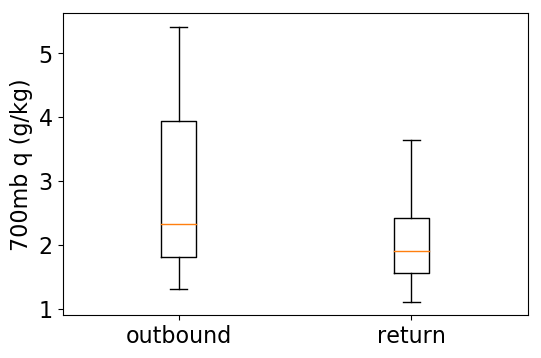

In [57]:
fig, ax = plt.subplots()
ax.boxplot([df.T[np.arange(1,19)].T.out_FT_q.values, df.T[np.arange(1,19)].T.ret_FT_q.values], labels=['outbound', 'return'])
ax.set_ylabel('700mb q (g/kg)')
fig.savefig(os.path.join(utils.plot_dir, "700mb_q_boxwhisker.png"), dpi=600, bbox_inches='tight')

In [443]:
nosave_list = ['out_median_prec', 'ret_median_prec', 'diff_median_prec', 'out_cond_prec_PZ', 'ret_cond_prec_PZ', 
 'diff_cond_prec_PZ', 'out_zi_traj', 'ret_zi_traj', 'diff_zi_traj', 'entr_TLC', 'dzidt_ALC']
df_save = df.drop(nosave_list, axis=1)
path = '/home/disk/eos4/jkcm/Data/CSET/Lagrangian_cases_table.xlsx'

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df_save.T.to_excel(writer,'raw')
writer.save()

In [ ]:
book = load_workbook('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_cases_table.xlsx')
writer = pd.ExcelWriter('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_cases_table.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
df.to_excel(writer, "Dump")

writer.save()

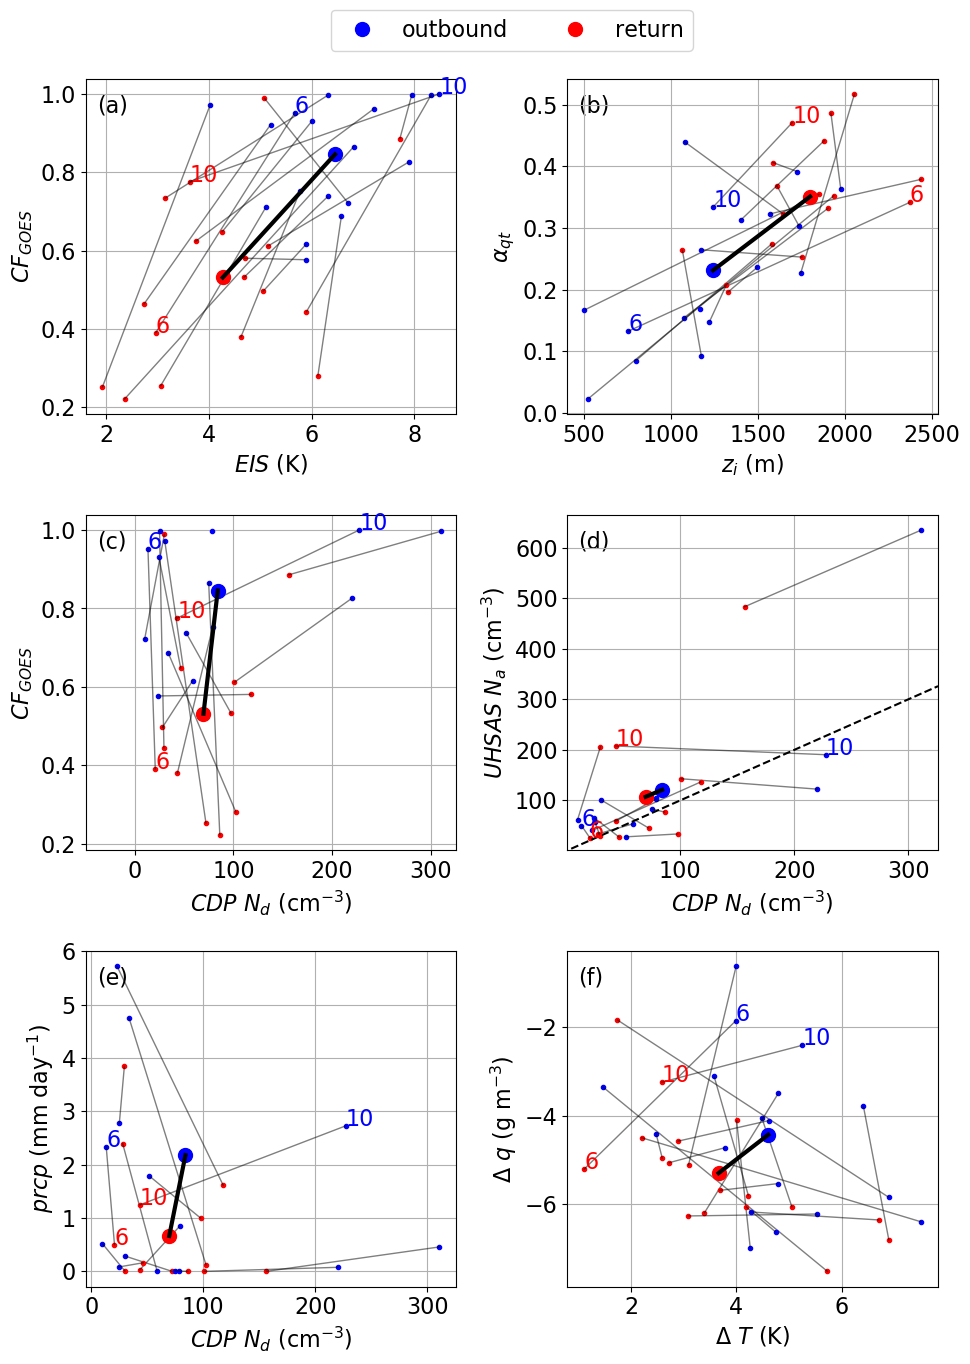

In [419]:
def plot_from_bigtable(df, var_a, var_b, a_name=None, b_name=None, title=None, ax=None, one2one=False):
    df = df.drop(['upper_quartile', 'lower_quartile', 'mean'], axis=0)
    if ax is None:
        fig, ax = plt.subplots()
    if a_name is None:
        a_name = var_a
    if b_name is None:
        b_name = var_b
    if title is None:
        title = var_a + " vs " + var_b
    for index, row in df.iterrows():
        if np.isnan(row['out_'+var_b]) or np.isnan(row['out_'+var_a]):
            continue
        ax.plot(row['out_'+var_b], row['out_'+var_a], '.', c='b')
        if index in [6, 10]:
            ax.annotate(s=str(index), xy=(row['out_'+var_b], row['out_'+var_a]), fontsize=16, color='b')
            ax.annotate(s=str(index), xy=(row['ret_'+var_b], row['ret_'+var_a]), fontsize=16, color='r')
        ax.plot(row['ret_'+var_b], row['ret_'+var_a], '.', c='r')
        ax.plot([row['out_'+var_b], row['ret_'+var_b]], [row['out_'+var_a], row['ret_'+var_a]], c='k', lw=1, alpha=0.5)
    ax.plot(np.nanmean(df['out_'+var_b]), np.nanmean(df['out_'+var_a]), '.', c='b', ms=20, label='outbound')
    ax.plot(np.nanmean(df['ret_'+var_b]), np.nanmean(df['ret_'+var_a]), '.', c='r', ms=20, label='return')
    ax.plot([np.nanmean(df['out_'+var_b]), np.nanmean(df['ret_'+var_b])], [np.nanmean(df['out_'+var_a]), np.nanmean(df['ret_'+var_a])], 
            c='k', lw=3)
    if one2one:
        xlims, ylims = list(ax.get_xlim()), list(ax.get_ylim())
        xlims[0] = max(xlims[0], 1)
        ylims[0] = max(ylims[0], 1)
        min_v = max(ax.get_xlim()[0], ax.get_ylim()[0])
        max_v = min(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([min_v, max_v], [min_v, max_v], 'k--', label='1-1 line')
        ax.set_ylim(ylims)
        ax.set_xlim(xlims)

    #ax.legend()
    
#     if var_a in ["CDP_Nd", "UHSAS_Na"]:
#         ax.set_yscale('log')
#     if var_b in ["CDP_Nd", "UHSAS_Na"]:
#         ax.set_xscale('log')
    
    
    ax.set_xlabel(b_name)
    ax.set_ylabel(a_name)
#     ax.set_title(title)
    ax.annotate('({})'.format(title[0]), xy=(0.03, 0.9), xycoords='axes fraction', backgroundcolor='white', fontsize=16, zorder=0)
    ax.grid(True)
    return ax
    
    
fig, [[ax1, ax2], [ax3,ax4], [ax5, ax6]] = plt.subplots(nrows=3, ncols=2, figsize=(11,16))
    
plot_from_bigtable(df, var_a='GOES_CF', var_b='EIS', a_name="$CF_{GOES}$", b_name="$EIS$ (K)", title="a) Cloud Fraction vs EIS", ax=ax1)
plot_from_bigtable(df, var_a='alpha_dec', var_b='zi', a_name=r'$\alpha_{qt}$', b_name=r'$z_i$ (m)', title='b) Decoupling vs Depth', ax=ax2)
plot_from_bigtable(df, var_a='GOES_CF', var_b='CDP_Nd', a_name="$CF_{GOES}$", b_name=r"$CDP\ N_d$ (cm$^{-3}$)", title=r'c) Cloud Fraction vs $N_d$', ax=ax3)
plot_from_bigtable(df, var_a='UHSAS_Na', var_b='CDP_Nd', a_name="$UHSAS\ N_a$ (cm$^{-3}$)", b_name="$CDP\ N_d$ (cm$^{-3}$)", title=r'd) $N_a$ vs $N_d$', ax=ax4, one2one=True)
# plot_from_bigtable(df, var_a='zi', var_b='EIS', a_name=r"$z_i$ (m)", b_name="$EIS$ (K)", title="e) Depth vs EIS", ax=ax5)
plot_from_bigtable(df, var_a='mean_prec', var_b='CDP_Nd', a_name=r"$prcp$ (mm day$^{-1}$)", b_name=r"$CDP\ N_d$ (cm$^{-3}$)", title="e) Depth vs EIS", ax=ax5)

plot_from_bigtable(df, var_a='delta_q', var_b='delta_T', a_name="$\Delta\ q$ (g m$^{-3}$)", b_name=r"$\Delta\ T$ (K)", title=r"f) $\Delta$ q vs $\Delta$ T", ax=ax6)

ax3.set_xlim(-50, ax3.get_xlim()[1])
all_cf = np.hstack([df['out_GOES_CF'].values,df['ret_GOES_CF'].values])
all_lts = np.hstack([df['out_LTS'].values,df['ret_LTS'].values])
all_eis = np.hstack([df['out_EIS'].values,df['ret_EIS'].values])

# slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(all_eis.tolist(), all_cf.tolist())

# xs = np.linspace(np.nanmin(all_eis), np.nanmax(all_eis), 50)
# ys = intercept2 + slope2*xs
# ax1.plot(xs, ys, 'k--', label='naive fit')
# h, l = ax1.get_legend_handles_labels()
# ax1.legend(h[2:], l[2:])
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax2.legend(loc='lower center', ncol=2, bbox_to_anchor=(-0.15, 1.05));

fig.savefig(os.path.join(utils.plot_dir, "4_changes_in_things.png"), dpi=600, bbox_inches='tight')

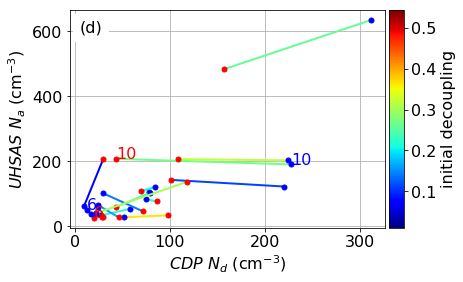

In [175]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')


import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots()
var_a='UHSAS_Na'
var_b='CDP_Nd'
a_name="$UHSAS\ N_a$ (cm$^{-3}$)"
b_name="$CDP\ N_d$ (cm$^{-3}$)"
title=r'd) $N_a$ vs $N_d$'
one2one=True

dec_min = min((df.ret_alpha_dec + df.out_alpha_dec)/2)
dec_max = max((df.ret_alpha_dec + df.out_alpha_dec)/2)
dec_min, dec_max = min(df.out_alpha_dec), max(df.out_alpha_dec)
norm = mpl.colors.Normalize(vmin=dec_min,vmax=dec_max)
x1, x2 = [], []
for index, row in df.iterrows():
    mean_dec = (row['out_alpha_dec'] + row['ret_alpha_dec'])/2
    mean_dec = row['out_alpha_dec']
    if np.isnan(row['out_'+var_b]) or np.isnan(row['out_'+var_a]):
        continue
    x2.append(mean_dec)

    if index in [6, 10]:
        ax.annotate(s=str(index), xy=(row['out_'+var_b], row['out_'+var_a]), fontsize=16, color='b')
        ax.annotate(s=str(index), xy=(row['ret_'+var_b], row['ret_'+var_a]), fontsize=16, color='r')
    color= cmap(norm(mean_dec))
    ax.plot([row['out_'+var_b], row['ret_'+var_b]], [row['out_'+var_a], row['ret_'+var_a]], c=color, lw=2, alpha=1)
    ax.plot(row['out_'+var_b], row['out_'+var_a], '.', c='b', ms=10)
    ax.plot(row['ret_'+var_b], row['ret_'+var_a], '.', c='r', ms=10)
    slope = (row['ret_'+var_a] - row['out_'+var_a])*1.0/(row['ret_'+var_b] - row['out_'+var_b])
    x1.append(slope)
    
ax.set_xlabel(b_name)
ax.set_ylabel(a_name)
#     ax.set_title(title)
ax.annotate('({})'.format(title[0]), xy=(0.03, 0.9), xycoords='axes fraction', backgroundcolor='white', fontsize=16)
ax.grid(True)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.jet, orientation='vertical', norm=norm)
plt.gcf().add_axes(ax_cb)
cb1.set_label('initial decoupling')
# ax_cb.set_yticklabels([np.around(i/2, 1) for i in ax_cb.get_yticks()])
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()
fig.savefig(os.path.join(utils.plot_dir, "rev_decoupling vs na-nd.png"), dpi=600, bbox_inches='tight')

In [270]:
# print("naive slope of lts {:0.1f}%/K".format(slope*100))
# print("naive slope of eis {:0.1f}%/K".format(slope2*100))
lts_slope = df['diff_GOES_CF'][:18]*100/df['diff_LTS'][:18]
eis_slope = df['diff_GOES_CF'][:18]*100/df['diff_EIS'][:18]
print("mean slope of lts: {:0.1f}%/K".format(np.nanmean(lts_slope)))
print("std dev slope of lts: {:0.1f}%/K".format(np.nanstd(lts_slope[lts_slope<100])))

print("mean slope of eis: {:0.1f}%/K".format(np.nanmean(eis_slope[eis_slope<70])))
print("median slope of eis: {:0.1f}%/K".format(np.nanmedian(eis_slope.values.astype(float))))

print("std dev slope of eis: {:0.1f}%/K".format(np.nanstd(eis_slope)))

lts_slope_2 = 100*(np.nanmean(df['out_GOES_CF'][:18])-np.nanmean(df['ret_GOES_CF'][:18]))/(np.nanmean(df['out_LTS'][:18])-np.nanmean(df['ret_LTS'][:18]))
eis_slope_2 = 100*(np.nanmean(df['out_GOES_CF'][:18])-np.nanmean(df['ret_GOES_CF'][:18]))/(np.nanmean(df['out_EIS'][:18])-np.nanmean(df['ret_EIS'][:18]))
print("slope of 'mean lts': {:0.1f}%/K\nslope of 'mean eis': {:0.1f}%/K".format(lts_slope_2, eis_slope_2))
dec_depth_slope = 1000*(np.nanmean(df['out_alpha_dec'][:18])-np.nanmean(df['ret_alpha_dec'][:18]))/(np.nanmean(df['out_zi'][:18])-np.nanmean(df['ret_zi'][:18]))
dec_depth_slope_2 = (1000*df['diff_alpha_dec'][:18]/df['diff_zi'][:18]).values.astype(float)
dec_depth_slope_2 = dec_depth_slope_2[np.abs(dec_depth_slope_2)<1]
print("slope of 'mean dec': {:0.2f}/km".format(dec_depth_slope))
print("mean slope of dec/depth: {:0.2f}/km".format(np.nanmean(dec_depth_slope_2)))
print("s.e.m. slope of dec/depth: {:0.2f}/km".format(np.nanstd(dec_depth_slope_2)/np.sqrt(len(dec_depth_slope_2))))

print("median slope of dec/depth: {:0.2f}/km".format(np.nanmedian(dec_depth_slope_2)))
print("std dev slope of dec/depth: {:0.2f}/km".format(np.nanstd(dec_depth_slope_2)))

mean slope of lts: 34.1%/K
std dev slope of lts: 24.0%/K
mean slope of eis: 15.9%/K
median slope of eis: 15.3%/K
std dev slope of eis: 21.6%/K
slope of 'mean lts': 14.4%/K
slope of 'mean eis': 14.4%/K
slope of 'mean dec': 0.21/km
mean slope of dec/depth: 0.17/km
s.e.m. slope of dec/depth: 0.08/km
median slope of dec/depth: 0.21/km
std dev slope of dec/depth: 0.32/km


In [271]:
x1, x2, x3, x4 = df['out_alpha_dec'][:18].values.astype(float), df['ret_alpha_dec'][:18].values.astype(float), \
                df['out_zi'][:18].values.astype(float), df['ret_zi'][:18].values.astype(float)
def fn(x1, x2, x3, x4): return 1000*(np.nanmean(x1)-np.nanmean(x2))/(np.nanmean(x3)-np.nanmean(x4))
list_o_vars = [x1, x2, x3, x4]             
def proper_bootstrap(fn, list_o_vars, samples=1000):
    results = []
    len_x = len(list_o_vars[0])
    for i in range(samples):
        idx = np.random.choice(len_x,len_x)
        ran_choices = list(zip(*np.array(list(zip(*list_o_vars)))[idx]))
        res = fn(*ran_choices)
        results.append(res)
    return results

results = proper_bootstrap(fn, list_o_vars)
print(np.nanmean(results))
print(np.nanstd(results))

0.2200767144345333
0.05635865097779263


In [16]:
all_nd = np.hstack([df['out_CDP_Nd'].values,df['ret_CDP_Nd'].values]).astype(float)
all_na = np.hstack([df['out_UHSAS_Na'].values,df['ret_UHSAS_Na'].values]).astype(float)
index = np.logical_and(~np.isnan(all_nd), ~np.isnan(all_na))
print(index)
slope, intercept, r_value, p_value, std_err = stats.linregress(all_nd[index].tolist(), all_na[index].tolist())
print(r_value)

[ True  True False  True  True  True  True False  True  True  True False
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True]
0.721026557496301


In [15]:
all_EIS = np.hstack([df['out_EIS'].values,df['ret_EIS'].values]).astype(float)
all_dt = np.hstack([df['out_delta_T'].values,df['ret_delta_T'].values]).astype(float)
index = np.logical_and(~np.isnan(all_EIS), ~np.isnan(all_dt))
print(index)
slope, intercept, r_value, p_value, std_err = stats.linregress(all_EIS[index].tolist(), all_dt[index].tolist())
print(r_value)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True]
0.4653240911482415


0.03658044290705569 0.583479825185928 0.12515742322656684
0.5191997461902842
LinregressResult(slope=0.021101114550466215, intercept=0.015307661576663429, rvalue=0.5163689280950002, pvalue=0.10391081794359561, stderr=0.011664968629360489)


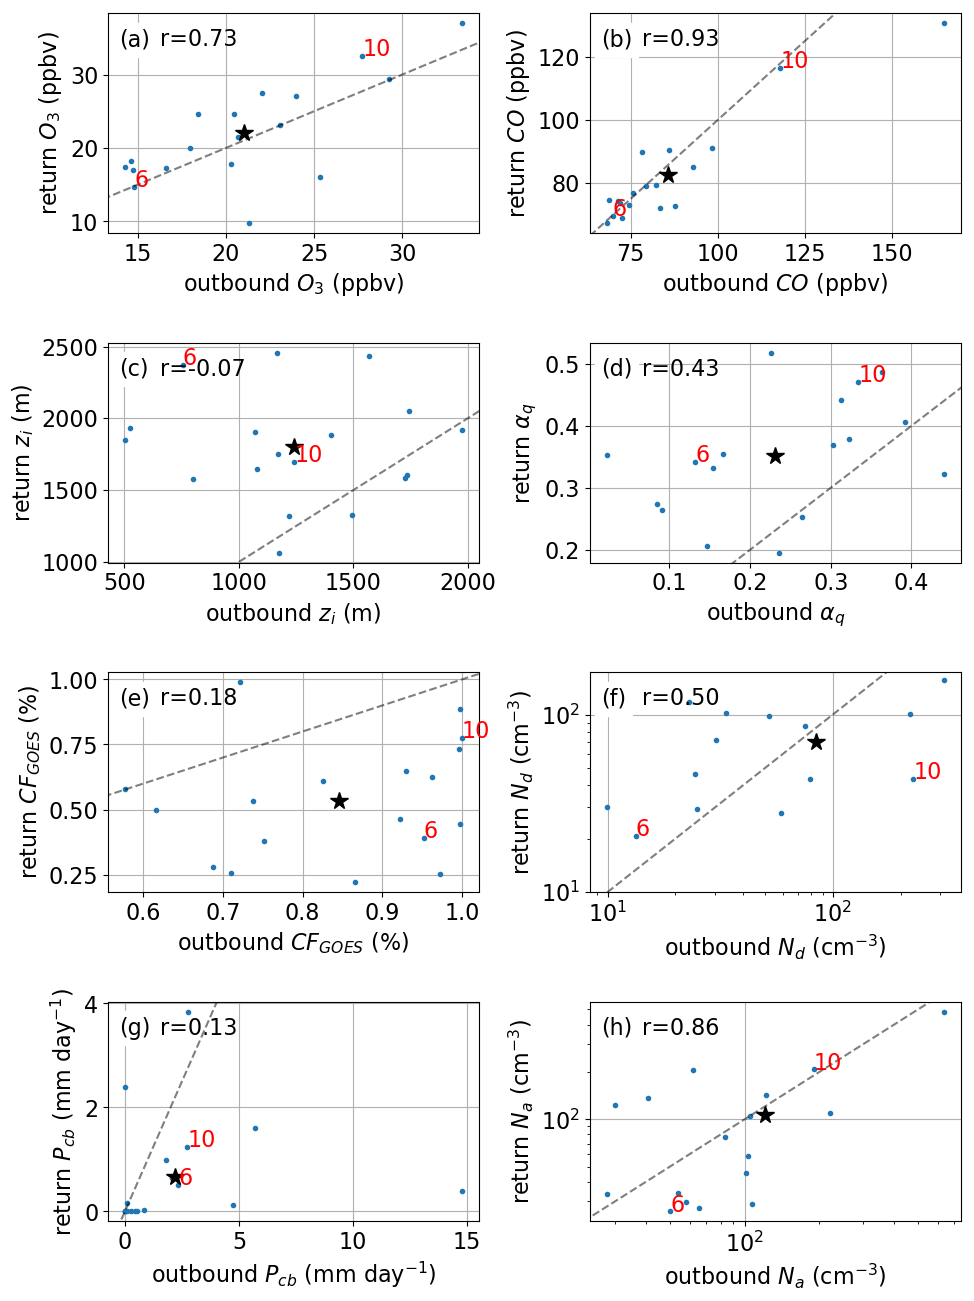

In [423]:
def plot_coherence(df, varname, label, units='', ax=None, pmeans=False):
    df = df.drop(['upper_quartile', 'lower_quartile', 'mean'], axis=0)
    if ax is None:
        fig, ax = plt.subplots()
    x_data = np.array(df['out_' + varname].values.astype(float))
    y_data = np.array(df['ret_' + varname].values.astype(float))
    ax.plot(x_data, y_data, '.')
    ax.plot(np.nanmean(x_data), np.nanmean(y_data), '*', ms=13, mfc='black', mec='black')
    if pmeans:
        print(np.nanmean(x_data), np.nanmean(y_data))
    if varname in ["CDP_Nd", "UHSAS_Na"]:
        ax.set_yscale('log')
        ax.set_xscale('log')
        
    
    
    for index, row in df.iterrows():
        if ~np.isnan(row['out_'+varname]) and  ~np.isnan(row['ret_'+varname]):
            if index in [6, 10]:
                ax.annotate(s=str(index), xy=(row['out_'+varname], row['ret_'+varname]), fontsize=16, color='red')

    
    
    end = ' ({})'.format(units) if units is not None else ""
    ax.set_xlabel('outbound ' + (label) + end)
    ax.set_ylabel('return ' + (label) + end)
    ax.grid(True)
    
    index = np.logical_and(~np.isnan(x_data), ~np.isnan(y_data))

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data[index], y_data[index])
    if varname == 'mean_prec':
        print(slope, intercept, r_value)
    ylims=ax.get_ylim()
    xlims=ax.get_xlim()
    
    min_v = min(xlims[0], ylims[0])
    max_v = max(xlims[1], ylims[1])
    xs = np.linspace(min_v, max_v, 10)
    ys = slope*xs + intercept
#     ax.plot(xs,ys, label="r^2: {:0.3f}".format(r_value**2))
#     ax.plot(xs,ys, label="best fit: r: {:0.3f}".format(r_value))

    

    ax.plot([min_v, max_v], [min_v, max_v], '--k', alpha=0.5, label='1-1 line')
#     ax.legend()
    ax.annotate('r={:0.2f}'.format(r_value), xy=(0.14, 0.85), xycoords='axes fraction', backgroundcolor='None', fontsize=16)

    
#     min_p = min(ax.get_xlim()[0], ax.get_ylim()[0])
#     max_p = max(ax.get_xlim()[1], ax.get_ylim()[1])
    
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    
#     rint("r-squared:", r_value**2)
#     r-squared: 0.08040226853902833
    
    
fig, [[ax1, ax2], [ax3,ax4], [ax5, ax6], [ax7, ax8]] = plt.subplots(nrows=4, ncols=2, figsize=(11,16))
   

plot_coherence(df, varname="O3", label='$O_3$', units="ppbv", ax=ax1)
plot_coherence(df, varname="CO", label='$CO$', units="ppbv", ax=ax2)
plot_coherence(df, varname="zi", label='$z_i$', units="m", ax=ax3)
plot_coherence(df, varname="alpha_dec", label=r'$\alpha_q$', units=None, ax=ax4)
plot_coherence(df, varname="GOES_CF", label='$CF_{GOES}$', units="%", ax=ax5)
plot_coherence(df, varname="CDP_Nd", label='$N_d$', units="cm$^{-3}$", ax=ax6)
plot_coherence(df, varname="mean_prec", label='$P_{cb}$', units="mm day$^{-1}$", ax=ax7)
plot_coherence(df, varname="UHSAS_Na", label=r'$N_a$', units="cm$^{-3}$", ax=ax8)


ax6.set_yticks([10, 100])

fig.subplots_adjust(hspace=0.5, wspace=0.3)

for axi, l in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], 'abcdefgh'):
    axi.annotate('({})'.format(l), xy=(0.03, 0.85), xycoords='axes fraction', backgroundcolor='white', fontsize=16)
""

fig.savefig(os.path.join(utils.plot_dir, "3_Lagrangian_coherence.png"), dpi=600, bbox_inches='tight')





Na_out = np.array(df['out_UHSAS_Na'].values.astype(float))
Na_ret = np.array(df['ret_UHSAS_Na'].values.astype(float))
index = np.logical_and(np.logical_and(~np.isnan(Na_out), ~np.isnan(Na_ret)),  Na_out < 500)
# index = np.logical_and(~np.isnan(Na_out), ~np.isnan(Na_ret))
slope, intercept, r_value, p_value, std_err = stats.linregress(Na_out[index], Na_ret[index])

print(r_value)

prcp_out = np.array(df['out_mean_prec'].values.astype(float))
prcp_ret = np.array(df['ret_mean_prec'].values.astype(float))
index = np.logical_and(np.logical_and(~np.isnan(prcp_out), ~np.isnan(prcp_ret)),  prcp_ret < 0.25)
# index = np.logical_and(~np.isnan(Na_out), ~np.isnan(Na_ret))
lr = stats.linregress(prcp_out[index], prcp_ret[index])
print(lr)

-133.7606389787462 -144.31481183369954


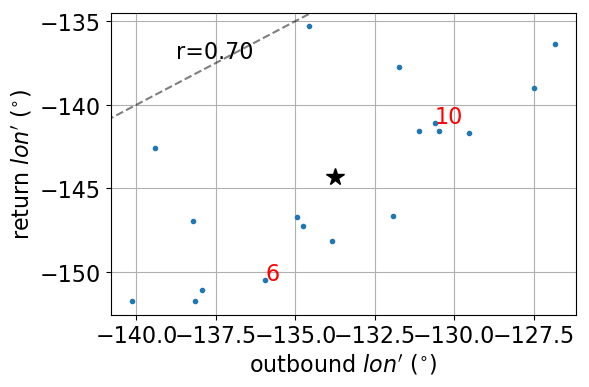

In [217]:
plot_coherence(df, varname="lon_p", label='$lon\'$', units="$^{\circ}$", pmeans=True)

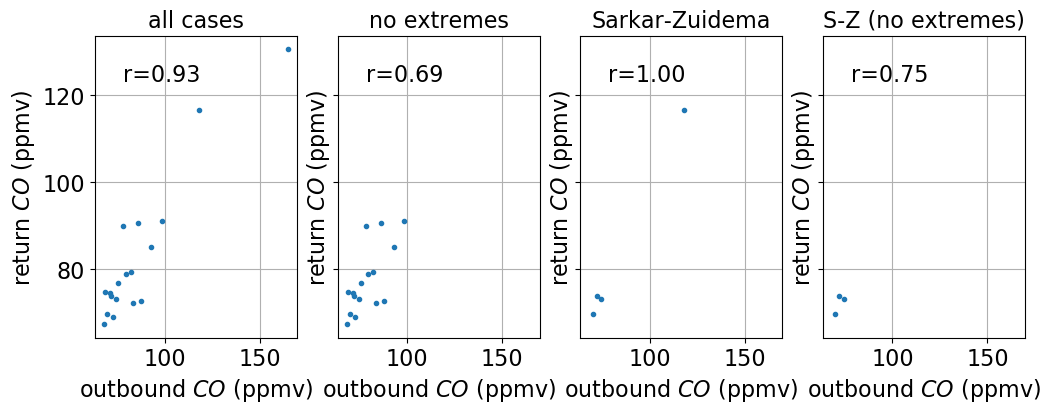

In [346]:
def plot_coherence_mod(df, varname, label, units='', ax=None):
    df = df.drop(['upper_quartile', 'lower_quartile', 'mean'], axis=0)
    if ax is None:
        fig, ax = plt.subplots()
    x_data = np.array(df['out_' + varname].values.astype(float))
    y_data = np.array(df['ret_' + varname].values.astype(float))
    ax.plot(x_data, y_data, '.')
    
    
    end = ' ({})'.format(units) if units is not None else ""
    ax.set_xlabel('outbound ' + (label) + end)
    ax.set_ylabel('return ' + (label) + end)
    ax.grid(True)
    
    index = np.logical_and(~np.isnan(x_data), ~np.isnan(y_data))

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data[index], y_data[index])
    if varname == 'mean_prec':
        print(slope, intercept, r_value)
    ylims=ax.get_ylim()
    xlims=ax.get_xlim()
    
#     min_v = min(xlims[0], ylims[0])
#     max_v = max(xlims[1], ylims[1])
#     xs = np.linspace(min_v, max_v, 10)
#     ys = slope*xs + intercept
#     ax.plot([min_v, max_v], [min_v, max_v], '--k', alpha=0.5, label='1-1 line')
    ax.annotate('r={:0.2f}'.format(r_value), xy=(0.14, 0.85), xycoords='axes fraction', backgroundcolor='None', fontsize=16)

    ax.set_ylim(ylims)
    ax.set_xlim(xlims)

hans_cases_less_top = df.drop([10, 1])

mampi_cases = [5,6,10,17,'upper_quartile', 'lower_quartile', 'mean']
mampi_cases_less_top = [5,6,17,'upper_quartile', 'lower_quartile', 'mean']

df_m = df.loc[mampi_cases]
df_m_lt = df.loc[mampi_cases_less_top]

fig, [ax1, ax2, ax3, ax4] = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=(12,4))
plot_coherence_mod(df, varname="CO", label='$CO$', units="ppmv", ax=ax1)
ax1.set_title("all cases")
plot_coherence_mod(hans_cases_less_top, varname="CO", label='$CO$', units="ppmv", ax=ax2)
ax2.set_title("no extremes")
plot_coherence_mod(df_m, varname="CO", label='$CO$', units="ppmv", ax=ax3)
ax3.set_title("Sarkar-Zuidema")
plot_coherence_mod(df_m_lt, varname="CO", label='$CO$', units="ppmv", ax=ax4)
ax4.set_title("S-Z (no extremes)")

fig.savefig(os.path.join(utils.plot_dir, 'CO comparison plot.jpg'), dpi=600, bbox_inches='tight')

In [341]:
df['ret_CO']

1                   130.6
2                    90.5
3                    74.7
4                    68.9
5                    73.8
6                    69.6
7                      85
8                    91.1
9                    74.4
10                  116.6
11                   72.1
12                   76.8
13                   72.6
14                   79.4
15                   78.9
16                   67.3
17                     73
18                   89.8
lower_quartile      69.39
upper_quartile      98.75
mean              82.5056
Name: ret_CO, dtype: object

In [356]:
df1 = df.drop(['upper_quartile', 'lower_quartile', 'mean'], axis=0)

prcp_out = np.array(df1['out_mean_prec'].values.astype(float))
prcp_ret = np.array(df1['ret_mean_prec'].values.astype(float))
index = np.logical_and(np.logical_and(~np.isnan(prcp_out), ~np.isnan(prcp_ret)),  prcp_ret < 0.25)
# index = np.logical_and(~np.isnan(prcp_out), ~np.isnan(prcp_ret))
lr = stats.linregress(prcp_out[index], prcp_ret[index])
print(lr)

LinregressResult(slope=0.11466529541124168, intercept=0.04762047755873742, rvalue=0.3677422989988275, pvalue=0.21638088120226642, stderr=0.08742613272139246)


In [276]:
combined_cases[6].TLC.traj_data['1.6']

<xarray.Dataset>
Dimensions:            (ens_level: 12, level: 37, number: 10, time: 73)
Coordinates:
  * time               (time) datetime64[ns] 2015-07-17T18:00:00 ...
  * level              (level) float64 1.0 2.0 3.0 5.0 7.0 10.0 20.0 30.0 ...
  * number             (number) int32 0 1 2 3 4 5 6 7 8 9
  * ens_level          (ens_level) int32 700 750 775 800 825 850 875 900 925 ...
Data variables:
    fhour              (time) timedelta64[ns] ...
    lat                (time) float64 ...
    lon                (time) float64 ...
    height             (time) float64 ...
    pres               (time) float64 ...
    traj_u             (time) float64 ...
    traj_v             (time) float64 ...
    traj_hdg           (time) float64 ...
    traj_spd           (time) float64 ...
    ERA_crwc           (time, level) float64 ...
    ERA_clwc           (time, level) float64 ...
    ERA_cc             (time, level) float64 ...
    ERA_w              (time, level) float64 0.0001278 0.000573

4 ret_insitu: nan,  ret_goes: 13.115081229108371
15 ret_insitu: nan,  ret_goes: 16.143396676887537


LinregressResult(slope=0.5129231620473244, intercept=29.60066744507834, rvalue=0.37183987485096404, pvalue=0.030357304031777232, stderr=0.22636446664485912)

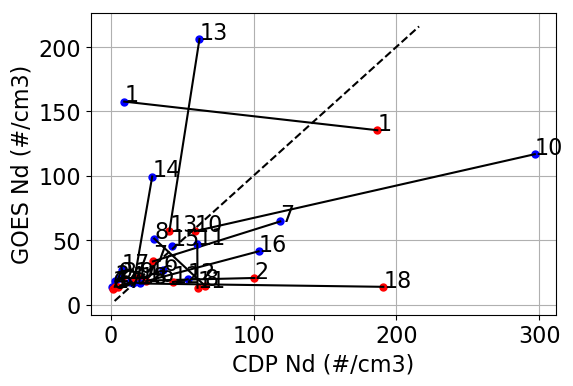

In [224]:
#aircraft vs GOES Nd
goes_nd = []
cdp_nd = []

goes_nd_all = {i: [] for i in [10, 25, 40, 50, 60, 75, 90]}
fig, ax = plt.subplots()
for key, case in combined_cases.items():
        
    out_nd_insitu = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
    varname='CONCD_LWOI', legname='p', cloud_only=True).values)
    ret_nd_insitu = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
    varname='CONCD_LWOI', legname='p', cloud_only=True).values)
    for k, v in goes_nd_all.items():
        out_nd_goes = np.nanpercentile(case.ALC.outbound_Flight_Piece.GOES_data['2deg'].Nd, k)
        ret_nd_goes =np.nanpercentile(case.ALC.return_Flight_Piece.GOES_data['2deg'].Nd, k)
        v.append(out_nd_goes)
        v.append(ret_nd_goes)

    
    out_nd_goes = np.nanpercentile(case.ALC.outbound_Flight_Piece.GOES_data['2deg'].Nd, 75)
    ret_nd_goes =np.nanpercentile(case.ALC.return_Flight_Piece.GOES_data['2deg'].Nd, 75)
    goes_nd.append(out_nd_goes)
    cdp_nd.append(out_nd_insitu)
    goes_nd.append(ret_nd_goes)
    cdp_nd.append(ret_nd_insitu)
    if not np.isnan(out_nd_insitu) or np.isnan(out_nd_goes):
        ax.plot(out_nd_insitu, out_nd_goes, 'b', marker='.', ms=10)
        plt.annotate(str(key), xy=(out_nd_insitu, out_nd_goes))
    else:
        print("{} out_insitu: {},  out_goes: {}".format(key, out_nd_insitu, out_nd_goes))
    if not np.isnan(ret_nd_insitu) or np.isnan(ret_nd_goes):
        ax.plot(ret_nd_insitu, ret_nd_goes, 'r', marker='.', ms=10)
        plt.annotate(str(key), xy=(ret_nd_insitu, ret_nd_goes))
    else:
        print("{} ret_insitu: {},  ret_goes: {}".format(key, ret_nd_insitu, ret_nd_goes))
    ax.plot([out_nd_insitu, ret_nd_insitu], [out_nd_goes, ret_nd_goes], 'k')
plt.plot([max([ax.get_ylim()[0], ax.get_xlim()[0]]), min([ax.get_ylim()[1], ax.get_xlim()[1]])],
         [max([ax.get_ylim()[0], ax.get_xlim()[0]]), min([ax.get_ylim()[1], ax.get_xlim()[1]])], 'k', ls='--')
ax.grid(True, which='major')
ax.grid(True, which='minor', ls='--')
ax.set_ylabel('GOES Nd (#/cm3)')
ax.set_xlabel('CDP Nd (#/cm3)');
# ax.set_yscale('log')
# ax.set_xscale('log')
idx = np.logical_and(~np.isnan(goes_nd), ~np.isnan(cdp_nd))
stats.linregress(np.array(goes_nd)[idx], np.array(cdp_nd)[idx])

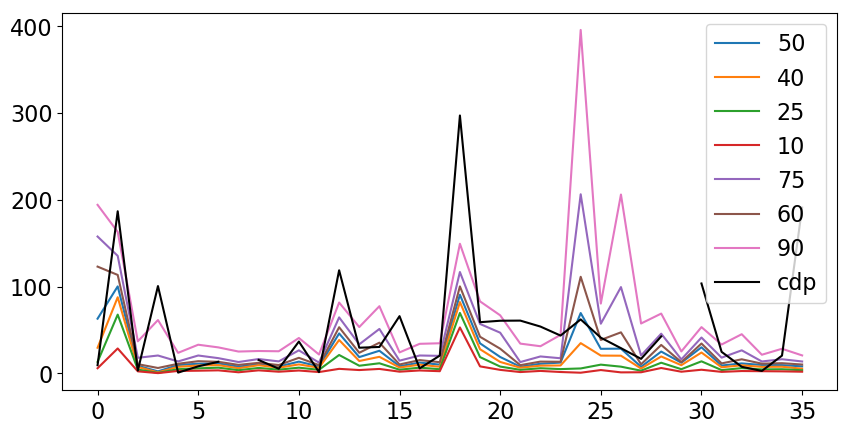

In [144]:
fig, ax = plt.subplots(figsize=(10,5))
for k, goes in goes_nd_all.items():
    ax.plot(goes, label=k)
ax.plot(cdp_nd, "k", label="cdp")
plt.legend()

In [149]:
cdp  = np.array(cdp_nd)
for k, goes in goes_nd_all.items():
    idx = np.logical_and(~np.isnan(goes), ~np.isnan(cdp))
    lr = stats.linregress(np.array(goes)[idx], np.array(cdp)[idx])
#     print(lr)
    bias = goes-cdp
    print("{}th pctile from goes: mean bias: {:0.0f}".format(k, np.nanmean(bias)))

50th pctile from goes: mean bias: -29
40th pctile from goes: mean bias: -35
25th pctile from goes: mean bias: -41
10th pctile from goes: mean bias: -47
75th pctile from goes: mean bias: -8
60th pctile from goes: mean bias: -22
90th pctile from goes: mean bias: 18


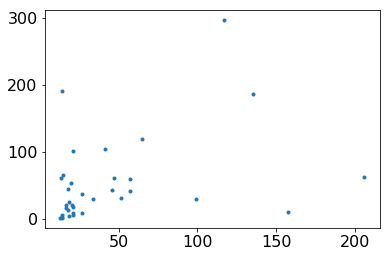

In [14]:
plt.plot(goes_nd, cdp_nd, '.')

In [357]:
all_aircraft_nd = np.hstack([df1['out_zi'].values,df1['ret_zi'].values]).astype(float)
all_goes_nd = goes_nd_all[75]
all_ERA_zi = np.hstack([df1['out_zi_traj'].values,df1['ret_zi_traj'].values]).astype(float)

all_CF = np.hstack([df1['out_GOES_CF'].values,df1['ret_GOES_CF'].values]).astype(float)
all_mean_prec = np.hstack([df1['out_mean_prec'].values,df1['ret_mean_prec'].values]).astype(float)
all_mean_prec_PZ = np.hstack([df1['out_mean_prec_PZ'].values,df1['ret_mean_prec_PZ'].values]).astype(float)

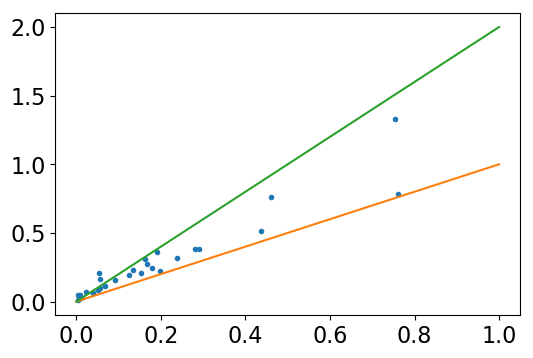

In [360]:
plt.plot(all_mean_prec, all_mean_prec_PZ, '.')
utils.nan_correlate(all_mean_prec, all_mean_prec_PZ)
plt.plot([0,1], [0,1])
plt.plot([0,1], [0,2])

In [143]:
all_aircraft_zi = np.hstack([df['out_zi'].values,df['ret_zi'].values])
all_ERA_zi = np.hstack([df['out_zi_traj'].values,df['ret_zi_traj'].values])

np.mean(all_aircraft_zi - all_ERA_zi)


# plt.plot(all_aircraft_zi, all_ERA_zi, '.')
# plt.plot([500,2500], [500, 2500])
# plt.ylabel('ERA')
# plt.xlabel('aircraft')

544.8155656106495

0.3667020992231311

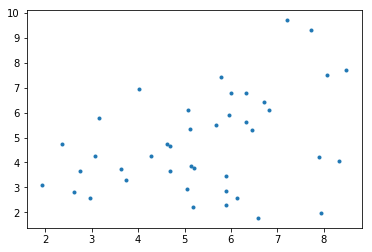

In [75]:
all_eis = np.hstack([df['out_EIS'].values,df['ret_EIS'].values]).astype('float')
all_delta_t = np.hstack([df['out_delta_T'].values,df['ret_delta_T'].values]).astype('float')
plt.plot(all_eis, all_delta_t, '.')
utils.nan_correlate(all_eis, all_delta_t)

In [384]:
x>0.01

array([False, False, False, ...,  True, False, False])

In [390]:
x

<xarray.DataArray 'lwf' (time: 1168)>
array([     nan,      nan,      nan, ..., 0.115467,      nan,      nan])
Coordinates:
  * time      (time) datetime64[ns] 2015-07-17T16:07:00 ...
    leg       (time) <U1 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' ...
    sequence  (time) <U1 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' ...

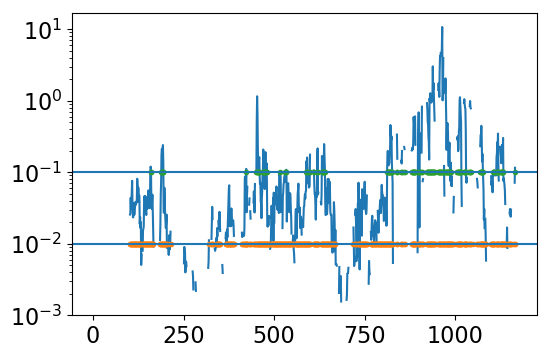

In [393]:
x = combined_cases[5].ALC.outbound_Flight_Piece.get_max_precip_by_leg(legname='b')*3.6
plt.plot(x)
plt.plot((x>0.01)/100, '.');
plt.plot((x>0.1)/10, '.');

plt.yscale('log')
plt.axhline(0.01)
plt.axhline(0.1)

rain-conditional rr: 0.23716603420441035
leg-mean rr (1): 0.0972988858274504
precip freq: 0.41025641025641024
leg-mean rr (2): 0.0972988858274504


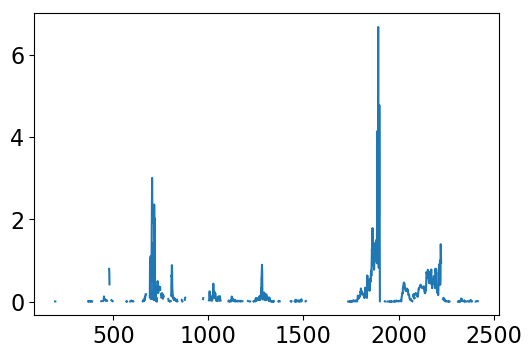

In [413]:
prcp = combined_cases[6].ALC.outbound_Flight_Piece.get_max_precip_by_leg(legname='b').values*3.6
rc_prec = np.nanmean(prcp)
print("rain-conditional rr: {}".format(rc_prec))
mean_prec = np.nansum(prcp)/len(prcp)
print("leg-mean rr (1): {}".format(mean_prec))
fq_prcp = sum(~np.isnan(prcp))/len(prcp)
print("precip freq: {}".format(fq_prcp))
print("leg-mean rr (2): {}".format(fq_prcp*rc_prec))
plt.plot(prcp)

In [361]:
 
#         df['out_mean_prec'][num] = np.nanmean(combined_cases[6].ALC.outbound_Flight_Piece.get_max_precip_by_leg(
#         legname='b').values*3.6)
#     out_prec_PZ = case.ALC.outbound_Flight_Piece.get_max_precip_by_leg(
#         legname='b').values*3.6
#     df['out_mean_prec_PZ'][num] = np.nanmean(out_prec_PZ[out_prec_PZ>0.01])

NameError: name 'all_cases' is not defined

In [89]:
x.columns

,out_time,ret_time,out_GOES_CF,ret_GOES_CF,diff_GOES_CF,out_EIS,ret_EIS,diff_EIS,out_LTS,ret_LTS,...,out_zi_traj,ret_zi_traj,diff_zi_traj,subs,entr,entr_TLC,dzidt_ALC,subs_700,shf,lhf
1,1.436290e+18,1.436474e+18,0.997243,0.886065,-0.111178,7.950623,7.720453,-0.230170,20.691885,20.362317,...,522.465357,572.874310,50.408953,-1.439416,1.629577,1.712294,0.190161,-6.874107,7.965453,84.250790
2,1.436293e+18,1.436468e+18,0.721257,0.989011,0.267754,6.713380,5.083241,-1.630139,20.265573,19.001996,...,540.997860,523.542596,-17.455264,-0.900170,0.937143,0.800275,0.036974,-5.128138,6.889760,81.486198
3,1.436719e+18,1.436907e+18,0.687373,0.280262,-0.407111,6.581055,6.123509,-0.457545,19.320410,19.164546,...,829.288300,744.413655,-84.874645,0.875046,-1.097964,-1.326718,-0.222918,-3.103780,7.625598,78.092379
4,1.436725e+18,1.436899e+18,0.615779,0.496688,-0.119091,5.892799,5.061400,-0.831400,18.867991,18.746289,...,976.930126,1207.072358,230.142232,1.728390,2.633783,-0.410603,4.362173,-3.087751,8.791246,108.660820
5,1.437150e+18,1.437337e+18,0.998279,0.443976,-0.554303,8.333402,5.901349,-2.432053,22.461205,18.465128,...,553.650834,818.679906,265.029073,0.059897,4.006400,1.359283,4.066297,-5.066880,8.206925,98.006294
6,1.437155e+18,1.437329e+18,0.951868,0.390778,-0.561090,5.677186,2.970348,-2.706838,19.910636,16.016624,...,572.894292,1353.211350,780.317058,0.626923,9.099060,3.860159,9.725984,-3.063461,9.868758,125.167630
7,1.437581e+18,1.437772e+18,0.826059,0.611100,-0.214959,7.892780,5.145826,-2.746954,19.369048,17.173609,...,589.852746,1183.850533,593.997787,-3.026548,7.715398,6.145711,4.688850,-5.088575,14.062711,121.154073
8,1.437585e+18,1.437765e+18,0.962015,0.623803,-0.338212,7.214528,3.745021,-3.469507,18.050135,16.618703,...,985.383095,1471.638831,486.255737,-3.602690,5.634833,6.303630,2.032143,-3.017578,16.166114,146.198049
9,1.437590e+18,1.437760e+18,0.738201,0.532052,-0.206149,6.318040,4.687971,-1.630069,18.252745,17.357046,...,1093.782683,1457.174494,363.391811,-1.412358,0.750265,3.544789,-0.662093,-2.413189,13.933679,150.295335
10,1.438015e+18,1.438203e+18,1.000000,0.775851,-0.224149,8.488096,3.627012,-4.861084,21.672540,16.431177,...,555.362936,1117.698308,562.335372,-2.740049,4.973426,5.731386,2.233377,-3.593582,10.213691,105.334155


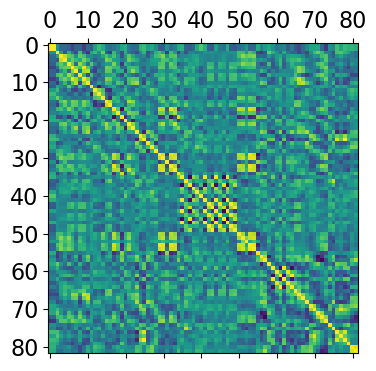

In [426]:
x = df.drop(['out_flight', 'out_seqs', 'ret_flight', 'ret_seqs', 'trajs'], axis=1).astype(float)
x = x.drop(['mean', 'upper_quartile', 'lower_quartile'], axis=0)
plt.matshow(x.corr())

masked = x.corr()
masked[np.abs(x.corr())<0.7] = 0
# plt.matshow(np.abs(x.corr())>0.8)
# plt.matshow(masked)

In [427]:
print("CF goes from {:0.3f} to {:0.3f}".format(np.nanmean(x['out_GOES_CF']), np.nanmean(x['ret_GOES_CF'])))


for i in x.columns:
    if i[:3] == 'out' and 'time' not in i:
        ret = 'ret'+ i[3:]
        diff = 'diff' + i[3:]
        mean = np.nanmean(x[diff])
        median = np.nanmedian(x[diff])
        dirn = 'increase' if mean>0 else 'decrease'
        agree = sum(np.sign(x[diff]) == np.sign(mean))
        median_agree = sum(np.sign(x[diff]) == np.sign(median))
        num = sum(~np.isnan(x[diff]))        
        print("for {}, mean change is {:0.3f}, and {}/{} agree".format(i[4:], mean, agree, num))
#         print("for {}, median change is {:0.3f}, and {}/{} agree".format(i[4:], median, median_agree, num))
#         corr = x.corr()[i][ret]
#         print("Lag coherence of {}: {:0.2f}".format(i[4:], corr))

CF goes from 0.846 to 0.531
for GOES_CF, mean change is -0.314, and 16/18 agree
for EIS, mean change is -2.185, and 18/18 agree
for LTS, mean change is -2.189, and 18/18 agree
for delta_q, mean change is -0.867, and 14/18 agree
for delta_T, mean change is -0.943, and 12/18 agree
for CDP_Nd, mean change is -14.866, and 5/14 agree
for CDP_Nd_p, mean change is 0.181, and 7/16 agree
for zi, mean change is 557.474, and 13/18 agree
for alpha_dec, mean change is 0.116, and 14/17 agree
for UHSAS_Na, mean change is -10.741, and 10/17 agree
for UHSAS_Na_cld, mean change is -7.368, and 7/13 agree
for median_prec, mean change is -0.819, and 11/15 agree
for prec_freq, mean change is -0.213, and 15/18 agree
for cond_prec, mean change is -1.153, and 12/15 agree
for mean_prec, mean change is -1.515, and 14/18 agree
for cond_prec_PZ, mean change is -0.977, and 12/15 agree
for O3, mean change is 0.931, and 14/18 agree
for CO, mean change is -3.256, and 12/18 agree
for SST, mean change is 3.489, and 18/1

In [136]:
print(np.nanmean(df['entr']*1000))
print(np.nanmean(df['entr_TLC']*1000))
df['entr_TLC']*1000

4.766537314699711
3.6610180052176795


1      1.71229
2     0.800275
3     -1.32672
4    -0.410603
5      1.35928
6      3.86016
7      6.14571
8      6.30363
9      3.54479
10     5.73139
11     7.77504
12     1.57597
13     3.01934
14      6.3467
15     6.23533
16      4.1638
17      6.7553
18     2.30663
Name: entr_TLC, dtype: object

In [60]:
x.corr()['diff_delta_T'][10:]

diff_LTS             0.461019
out_delta_q          0.213245
ret_delta_q         -0.418639
diff_delta_q        -0.320647
out_delta_T         -0.515449
ret_delta_T          0.822158
diff_delta_T         1.000000
out_CDP_Nd           0.092852
ret_CDP_Nd           0.225770
diff_CDP_Nd          0.319538
out_CDP_Nd_p        -0.235080
ret_CDP_Nd_p         0.560855
diff_CDP_Nd_p        0.597920
out_zi               0.175857
ret_zi               0.062569
diff_zi              0.054944
out_alpha_dec        0.149064
ret_alpha_dec       -0.070166
diff_alpha_dec      -0.052020
out_UHSAS_Na         0.073523
ret_UHSAS_Na         0.295288
diff_UHSAS_Na        0.455596
out_UHSAS_Na_cld     0.105922
ret_UHSAS_Na_cld     0.275779
diff_UHSAS_Na_cld    0.450456
out_mean_prec       -0.015788
ret_mean_prec        0.487165
diff_mean_prec       0.445316
out_O3              -0.004925
ret_O3               0.024490
diff_O3              0.141083
out_CO               0.085449
ret_CO               0.178552
diff_CO   

In [117]:
x.corr()

,out_GOES_CF,ret_GOES_CF,diff_GOES_CF,out_EIS,ret_EIS,diff_EIS,out_LTS,ret_LTS,diff_LTS,out_CDP_Nd,...,diff_O3,out_CO,ret_CO,diff_CO,out_SST,ret_SST,diff_SST,out_FT_RH,ret_FT_RH,diff_FT_RH
out_GOES_CF,1.000000,0.175418,-0.433190,0.288630,-0.213415,-0.519968,0.423221,-0.350910,-0.650877,0.350844,...,-0.248412,0.444993,0.275858,-0.577842,-0.643116,-0.445340,0.544463,0.316488,0.052029,-0.259446
ret_GOES_CF,0.175418,1.000000,0.811338,0.509347,0.436120,0.031248,0.516067,0.418520,-0.043440,0.432329,...,0.720388,0.600742,0.636890,-0.333531,-0.262179,-0.326375,0.097542,-0.176881,0.114035,0.208484
diff_GOES_CF,-0.433190,0.811338,1.000000,0.294923,0.525990,0.337357,0.221156,0.591519,0.346711,0.180541,...,0.778185,0.285748,0.419271,0.037767,0.141849,-0.034360,-0.233995,-0.349860,0.073505,0.344922
out_EIS,0.288630,0.509347,0.294923,1.000000,0.567523,-0.275709,0.707290,0.378430,-0.232525,0.623049,...,0.616067,0.508221,0.595855,-0.185833,-0.507098,-0.374656,0.409116,-0.435849,-0.055378,0.364512
ret_EIS,-0.213415,0.436120,0.525990,0.567523,1.000000,0.634974,0.426632,0.931870,0.483390,0.377513,...,0.571828,0.385404,0.411626,-0.208859,-0.104235,-0.179301,-0.003782,-0.413221,-0.311173,0.230845
diff_EIS,-0.519968,0.031248,0.337357,-0.275709,0.634974,1.000000,-0.165552,0.732856,0.782512,-0.124181,...,0.058174,-0.026903,-0.078516,-0.069473,0.354104,0.142202,-0.388278,-0.073476,-0.311324,-0.072508
out_LTS,0.423221,0.516067,0.221156,0.707290,0.426632,-0.165552,1.000000,0.302381,-0.534976,0.309726,...,0.531342,0.322796,0.327475,-0.204110,-0.530026,-0.510234,0.325691,-0.040054,0.077259,0.070027
ret_LTS,-0.350910,0.418520,0.591519,0.378430,0.931870,0.732856,0.302381,1.000000,0.643550,0.180840,...,0.466607,0.282321,0.346188,-0.077591,0.184284,0.059791,-0.214281,-0.471840,-0.133994,0.361767
diff_LTS,-0.650877,-0.043440,0.346711,-0.232525,0.483390,0.782512,-0.534976,0.643550,1.000000,-0.074867,...,-0.051477,-0.008966,0.043887,0.095126,0.588950,0.462712,-0.451458,-0.386056,-0.180806,0.264425
out_CDP_Nd,0.350844,0.432329,0.180541,0.623049,0.377513,-0.124181,0.309726,0.180840,-0.074867,1.000000,...,0.234250,0.870198,0.796014,-0.690061,-0.383827,-0.451123,0.163848,-0.299943,0.065605,0.311400


In [171]:
for i in x.corr().columns:
    if i[:3] == 'out':
        ret = 'ret'+ i[3:]
        corr = x.corr()[i][ret]
        print("Lag coherence of {}: {:0.2f}".format(i[4:], corr))

Lag coherence of GOES_CF: 0.18
Lag coherence of EIS: 0.58
Lag coherence of LTS: 0.31
Lag coherence of CDP_Nd: 0.50
Lag coherence of CDP_Nd_p: -0.07
Lag coherence of zi: 0.05
Lag coherence of alpha_dec: 0.46
Lag coherence of UHSAS_Na: 0.86
Lag coherence of mean_prec: -0.01
Lag coherence of O3: 0.82
Lag coherence of CO: 0.93


In [156]:
self, seq = combined_cases[10].ALC.outbound_Flight_Piece, 'A'  # works well
self, seq = combined_cases[10].ALC.return_Flight_Piece, 'D' # miss top of inv
self, seq = combined_cases[10].ALC.return_Flight_Piece, 'E' # theta OK, q bad
self, seq = combined_cases[12].ALC.outbound_Flight_Piece, 'D' # don't go deep enough
self, seq = combined_cases[13].ALC.outbound_Flight_Piece, 'A' # does great
self, seq = combined_cases[6].ALC.outbound_Flight_Piece, 'B' # does great

In [157]:
d = self.flight_data.where(
        np.logical_and(self.flight_data.leg=='d', self.flight_data.sequence==seq), drop=True)
var_list = ['GGLAT', 'GGLON', 'GGALT', 'RHUM', 'ATX', 'MR', 'THETAE', 'THETA', 'PSXC', 'DPXC', 'PLWCC']    


sounding_dict = {}
sounding_dict['TIME'] = d.time.values
for i in var_list:
    sounding_dict[i] = d[i].values
if 'ATX' in var_list:
    sounding_dict['ATX'] = sounding_dict['ATX'] + 273.15


sounding_dict['DENS'] = mu.density_from_p_Tv(d['PSXC'].values*100, d['TVIR'].values+273.15)  
sounding_dict['QL'] = d['PLWCC'].values/sounding_dict['DENS']
sounding_dict['THETAL'] = mu.get_liquid_water_theta(
    sounding_dict['ATX'], sounding_dict['THETA'], sounding_dict['QL'])
sounding_dict['QV'] = d['MR'].values/(1+d['MR'].values/1000)

In [186]:
    usetheta=False
    from met_utils import heffter_pblht_1D
    z = sounding_dict['GGALT']
    theta = sounding_dict['THETA']
    theta_e = sounding_dict['THETAE']
    qv = sounding_dict['QV']
    t = sounding_dict['ATX']

    if not usetheta:
        theta_l = sounding_dict['THETAL']
        ql = sounding_dict['QL']
        qt = qv + ql
    else:
        theta_l = sounding_dict['THETA']
        qt = qv
    if np.all(np.isnan(ql)):
        qt = qv


    zi = heffter_pblht_1D(z, theta)


    upper_25 = zi['z_bot'] - (zi['z_bot'] - min(z))/4.
    u_i = np.logical_and(z > upper_25, z < zi['z_bot'])
    lower_25 = min(z) + (zi['z_bot'] - min(z))/4.
    l_i = np.logical_and(z < lower_25, z > min(z))

    ft_base = zi['z_bot']+500
    ft_top = ft_base + 500
    l_ft = np.logical_and(z < ft_top, z > ft_base)

    #     mbl = z<zi['z_bot']
    #     print(np.nansum(ql[mbl])/np.nansum(qv[mbl]))

    #     if zi['z_bot'] - min(z) < 300 or np.sum(l_ft) == 0:
    #         return {"d_qt": np.nan, "d_theta_e": np.nan, "d_theta_l": np.nan,
    #                 "alpha_thetal": np.nan, "alpha_qt":np.nan, "alpha_thetae": np.nan,
    #                 "d_q_inv": np.nan, "d_t_inv": np.nan}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        theta_e_sml = np.nanmean(theta_e[l_i])
        theta_e_bzi = np.nanmean(theta_e[u_i])
        theta_e_uzi = np.nanmean(theta_e[l_ft])

        theta_l_sml = np.nanmean(theta_l[l_i])
        theta_l_bzi = np.nanmean(theta_l[u_i])
        theta_l_uzi = np.nanmean(theta_l[l_ft])

        qt_sml = np.nanmean(qt[l_i])
        qt_bzi = np.nanmean(qt[u_i])
        qt_uzi = np.nanmean(qt[l_ft])

    d_theta_e = theta_e_bzi - theta_e_sml
    d_theta_l = theta_l_bzi - theta_l_sml
    d_qt = qt_bzi - qt_sml

    alpha_thetal = (theta_l_bzi - theta_l_sml)/(theta_l_uzi - theta_l_sml)
    alpha_qt = (qt_bzi - qt_sml)/(qt_uzi - qt_sml)
    alpha_thetae = (theta_e_bzi - theta_e_sml)/(theta_e_uzi - theta_e_sml)

    # getting jumps across the inversion
    i_below_inv = np.logical_and(z > zi['z_bot']-50, z < zi['z_bot']+50)
    i_above_inv = np.logical_and(z > zi['z_top'], z < zi['z_top']+100)



    q_below_inv = np.nanmax(qt[i_below_inv])
    i_q_below_inv = np.nanargmin(qt[i_below_inv])
    z_q__below_inv = z[i_q_below_inv]
    q_above_inv = np.nanmin(qt[i_above_inv])
    i_q_above_inv = np.nanargmax(qt[i_above_inv])
    z_q_above_inv = z[i_q_above_inv]
    d_q_inv = q_above_inv - q_below_inv

    t_below_inv = np.nanmin(theta[i_below_inv])
    i_t_below_inv = np.nanargmin(theta[i_below_inv])
    z_t_below_inv = z[i_t_below_inv]
    t_above_inv = np.nanmax(theta[i_above_inv])
    i_t_above_inv = np.nanargmax(theta[i_above_inv])
    z_t_above_inv = z[i_t_above_inv]

    #     theta_below_inv = np.nanmean(theta_e_bzi)
    #     theta_above_inv = np.nanmean(theta_e_uzi) 
    d_t_inv = t_above_inv - t_below_inv

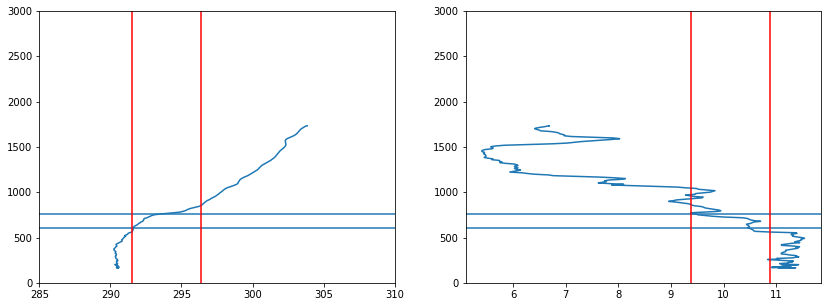

In [159]:
def make_delta_plots()


fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14,5))


ax1.plot(theta, z)
ax1.set_ylim(0,3000)
ax1.set_xlim(285, 310)
ax1.axhline(zi['z_bot'], label='inv base')
ax1.axhline(zi['z_top'], label='inv top')

ax1.axvline(t_below_inv, label='t_below_inv', c='r')
ax1.axvline(t_above_inv, label='t_above_inv', c='r')



ax2.plot(qt, z)
ax2.set_ylim(0,3000)
ax2.axhline(zi['z_bot'], label='inv base')
ax2.axhline(zi['z_top'], label='inv top')

ax2.axvline(q_below_inv, label='q_below_inv', c='r')
ax2.axvline(q_above_inv, label='q_above_inv', c='r')

0.23716603420441035


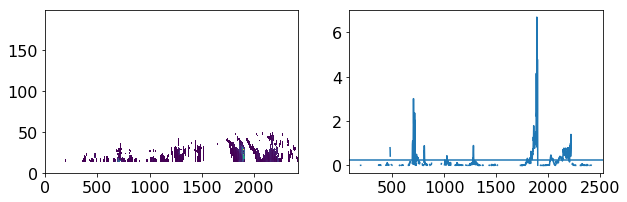

In [208]:
self = combined_cases[6].ALC.outbound_Flight_Piece
legname = 'b'
good_index = self.precip_data['leg'] == legname
prec = self.precip_data['lwf'][good_index]*3.6
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10,3))
ax1.pcolormesh(prec.T)
pmax = prec.max(dim='height', skipna=True)   
ax2.plot(pmax)
ax2.axhline(np.nanmean(pmax))
print(np.nanmean(pmax))

0.1628469766821342


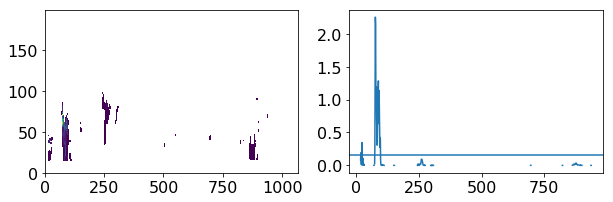

In [207]:
self = combined_cases[6].ALC.return_Flight_Piece
legname = 'b'
good_index = self.precip_data['leg'] == legname
prec = self.precip_data['lwf'][good_index]*3.6
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10,3))
ax1.pcolormesh(prec.T)
pmax = prec.max(dim='height', skipna=True)   
ax2.plot(pmax)
ax2.axhline(np.nanmean(pmax))
print(np.nanmean(pmax))